# Supervised learning

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>

In [424]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



---



<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

We start by loading in the pandas dataframe.

In [2]:
data = pd.read_csv('./nanoelectrodes_capacitance_samples.csv')
data_test = pd.read_csv('./nanoelectrodes_capacitance_test.csv')

In [3]:
X = data
X_test = data_test

We will consider the resultant electrical capacity (column ‘Capacitance (µF/cm²)’) as the target variable `y` to regress.

In [206]:
y = data['Capacitance ($\\mu F / cm^2$)']
y_test = data_test['Capacitance ($\\mu F / cm^2$)']

while the other 12 variables are our features.

In [207]:
column_names = data.columns.drop('Capacitance ($\\mu F / cm^2$)')

we create a dictionary `columns_dict` which indicates whether if a feature in the data set is numerical or categorical. For the dataframe that we have been provided with, all the columns are numerical.

In [11]:
# load data
training_data = pd.read_csv('nanoelectrodes_capacitance_samples.csv')
test_data = pd.read_csv('nanoelectrodes_capacitance_test.csv')

# split data to input and output
X_train, y_train = training_data.drop('Capacitance ($\mu F / cm^2$)', axis='columns'), training_data['Capacitance ($\mu F / cm^2$)']
X_test, y_test = test_data.drop('Capacitance ($\mu F / cm^2$)', axis='columns'), test_data['Capacitance ($\mu F / cm^2$)']

# for this dataset all features are numerical
columns_dict = {index: False for index in range(X_train.shape[1])}

Loss function of regression model

$\sum_{x_{in} \in R_1(j,s)} (y^{(i)} - \bar{y_{R1}})^2 + \sum_{x_{in} \in R_2(j,s)} (y^{(i)} - \bar{y_{R2}})^2$


In [4]:
def var_red(y):
    """
    Calculate the loss of values.
    Arguments:
        y: vector of training values, of shape (N,).
    Returns:
        (float): the loss for y
    """
    
    #calculate y bar
    y_bar = np.mean(y, keepdims=True)

    return np.sum((y - y_bar) ** 2)

Splitting the samples is performed the same way as the classification model suggested in the coding task. However, we do not need account for sample weights

In [5]:
def split_samples(X, y, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case `column` is categorical, or
      2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training values, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold the samples
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
    """

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, we split X, y.
    X_l, y_l = X[left_mask, :], y[left_mask]
    X_r, y_r = X[~left_mask, :], y[~left_mask]

    return (X_l, y_l), (X_r, y_r)

In [6]:
def split_value(X, y, column, categorical):

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    index_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        new_cost = var_red(y_l) + var_red(y_r)
        if new_cost < index_val:
              index_val, threshold = new_cost, value

    return index_val, threshold

In [7]:
def split(X, y, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training values, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_index = np.inf
    split_column = None
    split_val = np.nan

    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        index, current_split_val = split_value(X, y, column, categorical)


        if index < min_index:
            # Keep track with:

            # 1. the current minimum index value
            min_index = index

            # 2. corresponding column,
            split_column = column

            # 3. corresponding split threshold.
            split_val = current_split_val

    return split_column, split_val

Instead of performing majority vote to find the label which appears the most in label variable `y`,\
we simply take the mean value. we will define this as `pick` just to make it more intuitive.

In [8]:
def pick(y):
    """
    Args:
        y: vector of training values, of shape (N,).
    Returns:
        (int): mean
    """
    
    return np.mean(y)

The `build_tree` and `train` function are the same as the classification model except we have the mean value instead of majority labels

In [9]:
# EDIT THIS FUNCTION
def build_tree(X, y, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum of depth of the decision tree.
        min_samples_leaf (int): minimum of samples required to be a valid node
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'mean_value': For leaf nodes, this stores the mean value. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
        Example:
            mytree = {
                'feature_name': 'petal length (cm)',
                'feature_index': 2,
                'value': 3.0,
                'categorical': False,
                'mean_value': None,
                'left': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'mean_value': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
                'right': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'mean_value': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
            }
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': pick(y)}

    split_index, split_val = split(X, y, columns_dict)

    # If no valid split at this node, use mean value.
    if split_index is None:
        return {'mean_value': pick(y)}

    categorical = columns_dict[split_index]

    # Split samples (X, y, sample_weights) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'mean_value': None,
        'left': build_tree(X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

def train(X, y,  columns_dict):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    """

    feature_names = X.columns.tolist()
    
    X = X.to_numpy()
    
    y = y.to_numpy()
    
    return build_tree(X, y, columns_dict, feature_names, depth=1)

In [12]:
split_value(X_train.to_numpy(), y_train.to_numpy(), 1, columns_dict[1])

(3523534.6399717648, 1.78)

In [13]:
split(X_train.to_numpy(), y_train.to_numpy(), columns_dict)

(5, 2.5)

Create the decision tree usin the training data

In [14]:
tree = train(X_train, y_train, columns_dict)

In [15]:
tree

{'feature_name': 'Current_Density ($A/g$)',
 'feature_index': 5,
 'value': 2.5,
 'categorical': False,
 'mean_value': None,
 'left': {'feature_name': 'Doped_Oxygen_Percentage',
  'feature_index': 3,
  'value': 15.1,
  'categorical': False,
  'mean_value': None,
  'left': {'feature_name': 'Doped_Nitrogen_Percentage',
   'feature_index': 2,
   'value': 1.1,
   'categorical': False,
   'mean_value': None,
   'left': {'mean_value': 356.2857142857143},
   'right': {'feature_name': 'Doped_Sulfur_Percentage',
    'feature_index': 4,
    'value': 2.69,
    'categorical': False,
    'mean_value': None,
    'left': {'feature_name': 'Defect_Ratio',
     'feature_index': 1,
     'value': 1.25,
     'categorical': False,
     'mean_value': None,
     'left': {'feature_name': 'Surface_Area ($m^2/g$)',
      'feature_index': 0,
      'value': 109.07,
      'categorical': False,
      'mean_value': None,
      'left': {'mean_value': 154.99},
      'right': {'feature_name': 'Doped_Oxygen_Percentage',
 

We use the `classify` function from the coding tasks, which will traverse a given decision tree basen on the current feature vector that we have.

In [16]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['mean_value'] is not None:
        return tree['mean_value']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)

    else:

        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)

We will take the wrapper function `predict` from the coding task, which calls this `classify` function.

In [17]:
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

define `mse_cal` and `r2_score` which calculates the MSE value and the $R^{2}$ score respectively

In [138]:
## EDIT THIS FUNCTION
def mse_cal(y_pred, y_test):
    
    assert y_test.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_test = y_test.reshape(y_pred.shape)


    return np.mean((y_test - y_pred)**2, keepdims=True)

def r2_score(y_pred, y_test):
    
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    
    y_test = y_test.reshape(y_pred.shape)
    y_bar = y_test.mean()
    
    ss_tot = ((y_test - y_bar)**2).sum()
    ss_res = ((y_test - y_pred)**2).sum()
    
    return 1 - (ss_res/ss_tot)

Print the MSE values and the $R^{2}$ scores for train set and test set using the decision tree regression model

In [139]:
print('Training mse:', mse_cal(predict(tree, X_train.to_numpy()), y_train.to_numpy()))
print('Test mse:', mse_cal(predict(tree, X_test.to_numpy()), y_test.to_numpy()))

Training mse: [1654.4051507]
Test mse: [3369.56710698]


In [140]:
print('Training r:', r2_score(predict(tree, X_train.to_numpy()), y_train.to_numpy()))
print('Test r:', r2_score(predict(tree, X_test.to_numpy()), y_test.to_numpy()))

Training r: 0.7503640060081044
Test r: 0.4896216113769649


As we can see from above, the test MSE value is much higher than the training MSE value and the test $R^{2}$ score is much lower than the training $R^{2}$ score.\
Therefore, we can conclude that there is significant overfitting for this decision tree regression model.

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

As an attempt to reduce overfiting, we will implement the random forest model. \
The first random forest model that we will be implementing only uses bagging (and no feature bagging).

The `split_rf` function is almost identical to `split`. However, it takes an argument `n_features` which determines the number of sampled features for the random forest model.

In [141]:
def split_rf(n_features, X, y, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training values, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized MSE value, the best feature index and value used in splitting.
    """

    # The added sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_index, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        index, val = split_value(X, y, column, categorical)
        if index < min_index:
            min_index, split_column, split_val = index, column, val

    return min_index, split_column, split_val

In [142]:
def build_tree_rf(n_features, X, y, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum of depth of the decision tree.
        min_samples_leaf (int): minimum of samples required to be a valid node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'mean_value': For leaf nodes, this stores the mean value. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
        Example:
            mytree = {
                'feature_name': 'petal length (cm)',
                'feature_index': 2,
                'value': 3.0,
                'categorical': False,
                'mean_value': None,
                'left': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'mean_value': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
                'right': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'mean_value': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
            }
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': pick(y)}

    else:
        var_ind, split_column, split_val = split_rf(n_features, X, y, columns_dict)

        # If var_ind is infinity, it means that samples are not seperable by the sampled features.
        if var_ind == np.inf:
            return {'mean_value': pick(y)}
        categorical = columns_dict[split_column]
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val, categorical)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'categorical': categorical,
            'mean_value': None,
            'left': build_tree_rf(n_features, X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [143]:
def train_rf(B, n_features, X, y,  columns_dict, max_depth=10, min_samples_leaf=10):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        max_depth (int): maximum of depth of the decision tree.
        min_samples_leaf (int): minimum of samples required to be a valid node.
    """
    
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indexes = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indexes, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample,
                             columns_dict, feature_names, depth=1, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        trees.append(tree)

    return trees

In the `predict_rf` function, unlike the `aggregate` function in `predict` for decison tree regression model, we use `average` which simply obtains the average of all the
predictions made by the ensemble of decision trees.

In [144]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def average(decisions):
        """
        This function takes a list of predicted labels produced by a list
        of decision trees and returns the label with the majority of votes.
        """
        return np.mean(decisions) # <- SOLUTION

    if len(X.shape) == 1:
        # if we have one sample
        return average([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([average([classify(tree, x) for tree in rf]) for x in X])

In order to find the ideal value of B (the number of trees), we have to perform the five-fold cross-validation.

In [279]:
def cross_validation_mse(X_train, y_train, n_features, columns_dict, B, max_depth=10, min_samples_leaf=10):
    
    mse_list = []
    
    N = X_train.shape[0]
    fold_size = N // 5
    
    scores = []
    
    for i in range(5):
        
        val_indexes = list(range(i * fold_size, (i + 1) * fold_size))
        train_indexes = list(set(range(N)) - set(val_indexes))

        X_train_i = X_train.iloc[train_indexes]
        y_train_i = y_train.iloc[train_indexes]


        X_val_i = X_train.iloc[val_indexes]
        y_val_i = y_train.iloc[val_indexes]
        
        rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth=max_depth,
                      min_samples_leaf=min_samples_leaf)
        
        val = mse_cal(predict_rf(rf, X_val_i.to_numpy()), y_val_i.to_numpy())
        
        mse_list.append(val)

    # Return the average score
    return sum(mse_list) / len(mse_list) # <- SOLUTION

In [487]:
def choose_best_B(X_train, y_train, n_features, columns_dict, B_range):
    B_scores = np.zeros((len(B_range),))
    
    for i, b in enumerate(B_range):
        
        B_scores[i] = cross_validation_mse(X_train, y_train, n_features, columns_dict, b)

    best_B_index = np.argmin(B_scores)
    
    print(f'Best B : {B_range[best_B_index]}')
    
    plt.plot(B_range, B_scores)
    plt.xlabel('B')
    plt.ylabel('MSE')
    
    plt.show()
    
    return B_range[best_B_index]

Best B : 24


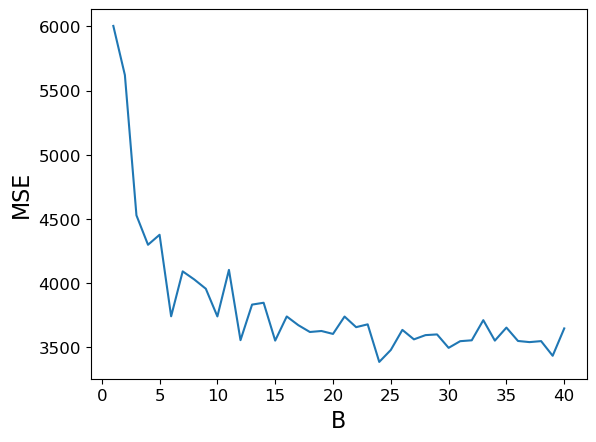

In [488]:
best_B = choose_best_B(X_train, y_train, X_train.shape[1] // 3, columns_dict, np.arange(1, 41))

In [489]:
best_B

24

In [517]:
trees_rf = train_rf(best_B, X_train.shape[1] // 3, X_train, y_train, columns_dict)

In [518]:
print(mse_cal(predict_rf(trees_rf, X_train.to_numpy()), y_train.to_numpy()))

print(r2_score(predict_rf(trees_rf, X_train.to_numpy()), y_train.to_numpy()))

print(mse_cal(predict_rf(trees_rf, X_test.to_numpy()), y_test.to_numpy()))

print(r2_score(predict_rf(trees_rf, X_test.to_numpy()), y_test.to_numpy()))

[1268.94012672]
0.8085274760434369
[2919.79001345]
0.5577480207786133


In [539]:
trees_bag = train_rf(best_B, X_train.shape[1], X_train, y_train, columns_dict)

In [540]:
print(mse_cal(predict_rf(trees_bag, X_train.to_numpy()), y_train.to_numpy()))

print(r2_score(predict_rf(trees_bag, X_train.to_numpy()), y_train.to_numpy()))

print(mse_cal(predict_rf(trees_bag, X_test.to_numpy()), y_test.to_numpy()))

print(r2_score(predict_rf(trees_bag, X_test.to_numpy()), y_test.to_numpy()))

[1010.84723381]
0.8474715495897953
[2873.18645214]
0.5648069247173371


(0.0, 4000.0)

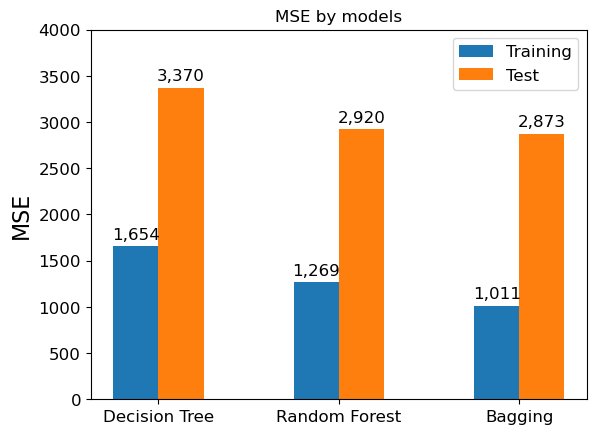

In [541]:
figsize=(12, 10)

models = ("Decision Tree", "Random Forest", "Bagging")

Training_list_1 = [predict(tree, X_train.to_numpy()), predict_rf(trees_rf, X_train.to_numpy()), predict_rf(trees_bag, X_train.to_numpy())]

Test_list_1 = [predict(tree, X_test.to_numpy()), predict_rf(trees_rf, X_test.to_numpy()), predict_rf(trees_bag, X_test.to_numpy())]

MSEs = {
    'Training': [mse_cal(y_pred, y_train.to_numpy()).item() for y_pred in Training_list_1],
    'Test': [mse_cal(y_pred, y_test.to_numpy()).item() for y_pred in Test_list_1]}

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


for data, values in MSEs.items():
    
    offset = width * multiplier
    
    rects = plt.bar(x + offset, values, width, label=data)
    
    plt.bar_label(rects, padding=3, fmt='{:,.0f}')
    
    multiplier += 1
    
plt.ylabel('MSE')
plt.title('MSE by models')
plt.xticks(x + width/2, methods)
plt.legend()
plt.ylim(0, 4000)

From the bar plot above, we can see that the bagging model has the best performance out of the three models and the normal random forest is an improvement over the decision tree regression model. This proves that the attempt to reduce overfitting by implementing the random forest model was successful.

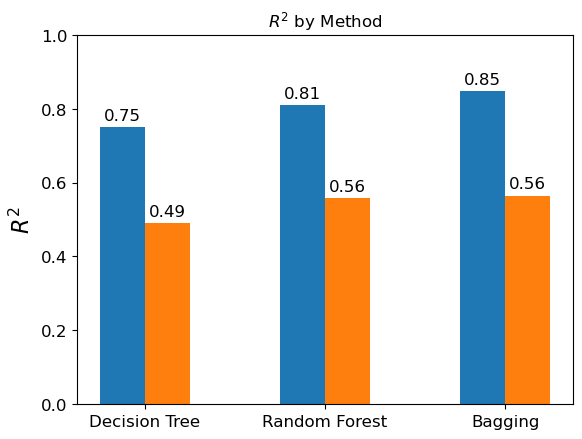

In [542]:
figsize=(12, 10)

x = np.arange(len(methods)) # the label locations
width = 0.25 # the width of the bars
multiplier = 0 # initlaize the multiplier

R2s = {    
    'Training': [r2_score(y_pred, y_train.to_numpy()).item() for y_pred in Training_list_1],
    'Test': [r2_score(y_pred, y_test.to_numpy()).item() for y_pred in Test_list_1]}

for data, values in R2s.items():
    
    offset = width*multiplier
    
    rects = plt.bar(x + offset, values, width, label = data)
    
    plt.bar_label(rects, padding=3, fmt='%.2f')
    
    multiplier += 1
    
plt.ylabel(r"$R^2$")
plt.title(r"$R^2$ by Method")
plt.xticks(x + width/2, models)
plt.ylim(0, 1)
plt.show()

We can see the same trend for $R^{2}$ scores as well.

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)

Now that we found the optimal B value for the random forest, we will now search for the optimal values of `max_depth` and `min_samples_leaf` using five-fold cross-validation while keeping B fixed.

In [922]:
def choose_best_par(X_train, y_train, X_test, y_test, best_B, columns_dict):
    """
    Find the ideal max_depth and min_samples_leaf for the random forest model.
    Args:
        X_train: (pd.Dataframe) training features, of shape (N, p).
        y_train: (pd.Series) vector of training labels, of shape (N,).
        X_test: (pd.Dataframe) testing sample features, of shape (N, p).
        y_test: (pd.Series) vector of testing sample labels, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int): the ideal B.
    """
    m, n = 6, 12
    
    max_d = np.arange(1, n+1, 1)
    min_s_l = np.arange(1, m+1, 1)
    
    MSEs = np.zeros((m, n))
    
    ideal_vals = (max_d[0], min_s_l[0])
    
    ideal_MSE = np.inf

    m_d_bar = tqdm(max_d)
    
    for count1, max_depth in enumerate(m_d_bar):
        
        m_s_l_bar = tqdm(min_s_l)
        
        for count2, min_samples_leaf in enumerate(m_s_l_bar):

            mean_MSE = cross_validation_mse(X_train, y_train, X_train.shape[1] // 3, columns_dict, best_B,
                                                     max_depth, min_samples_leaf)

            if mean_MSE < ideal_MSE:
                ideal_MSE = mean_MSE
                ideal_vals = (max_depth, min_samples_leaf)

            trees_rf = train_rf(best_B, X_train.shape[1]//3, X_train, y_train, columns_dict, max_depth, min_samples_leaf)

            # compute loss at the end of each epoch
            MSEs[count2, count1] = mean_MSE
        
    cmap = plt.colormaps['afmhot']
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set(title=r"$\langle MSE \rangle$ for Different Values of max_depth and min_samples_leaf", 
           xlabel ="max_depth", ylabel ="min_samples_leaf", xticks=max_d, yticks=min_s_l)
    contour = ax.pcolormesh(max_d, min_s_l, MSEs, shading='auto', cmap=cmap)
    fig.colorbar(contour, ax=ax, label=r"$\langle MSE \rangle$")
            
    plt.show()

    return ideal_vals

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

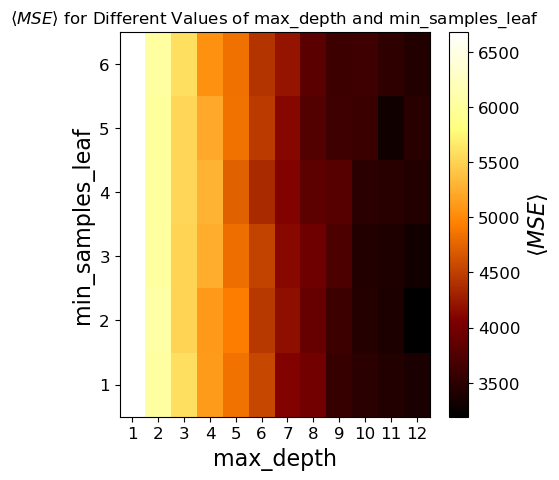

(12, 2)


In [923]:
ideal_vals = choose_best_par(X_train, y_train, X_test, y_test, best_B, columns_dict)

print(ideal_vals)

As we can see from the contour plot above, `min_samples_leaf` has very little influence on the MSE values of the prediction. `max_depth` is a much more dominant factor in the variance in the MSE values and we can predict that if try out higher `max_depth` values the MSE values will continue to decrease. However, it will take much longer to create the tree due to increased computational costs.

In [952]:
print(ideal_vals)

(12, 2)


Use the ideal parameters to train the data

In [1005]:
best_trees_rf = train_rf(best_B, X_train.shape[1] // 3, X_train, y_train, columns_dict, max_depth=ideal_vals[0], min_samples_leaf=ideal_vals[1])

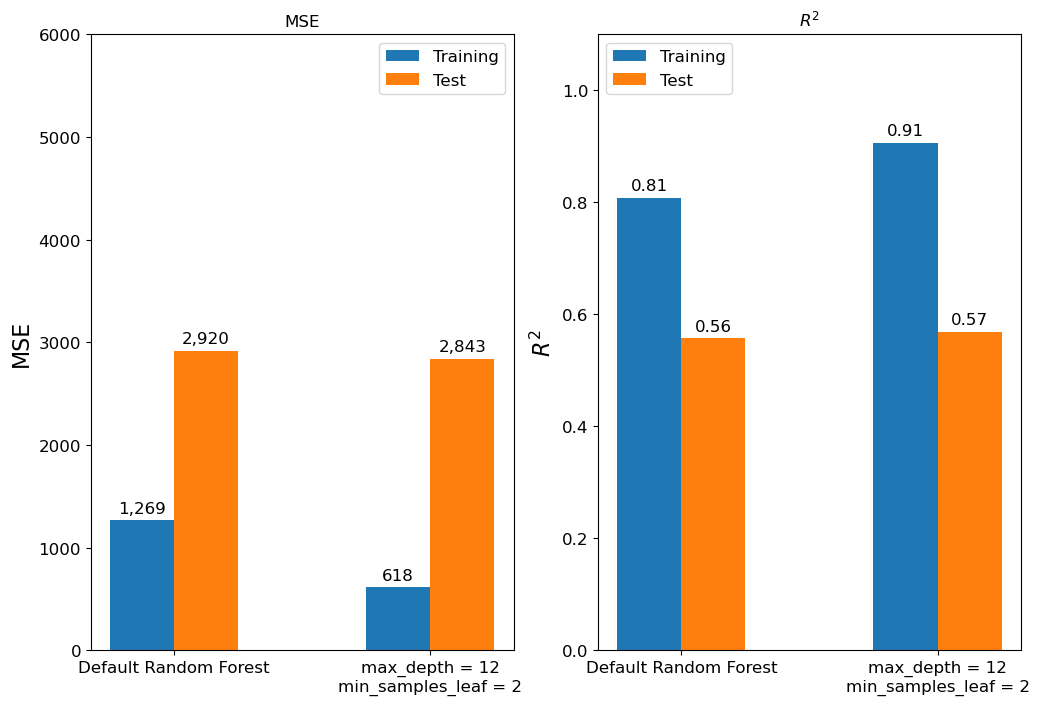

In [1018]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

models_tuple = ("Default Random Forest", 
           f"max_depth = {ideal_vals[0]}\nmin_samples_leaf = {ideal_vals[1]}") # tuple of methods

for_training = [predict_rf(trees_rf, X_train.to_numpy()), predict_rf(best_trees_rf, X_train.to_numpy())]

for_testing = [predict_rf(trees_rf, X_test.to_numpy()), predict_rf(best_trees_rf, X_test.to_numpy())]
# Calculate the MSE and R^2 score for each method
MSE_vals_list = {'Training': [mse_cal(y_train.to_numpy(), y_pred).squeeze() for y_pred in for_training], 'Test': [mse_cal(y_test.to_numpy(), y_pred).squeeze() for y_pred in for_testing]}

R2s_list = {'Training': [r2_score(y_pred, y_train.to_numpy()) for y_pred in for_training],
    'Test': [r2_score(y_pred, y_test.to_numpy()) for y_pred in for_testing]}

x = np.arange(len(models_tuple)) # the label locations
width = 0.25 # the width of the bars
multiplier = 0 # initlaize the multiplier

for data, values in MSE_vals_list.items():
    offset = width*multiplier
    rects = ax1.bar(x + offset, values, width, label=data)
    ax1.bar_label(rects, padding=3, fmt='{:,.0f}')
    multiplier += 1

ax1.set_ylabel('MSE')
ax1.set_title('MSE')
ax1.set_xticks(x + width / 2, models_tuple)
ax1.legend()
ax1.set_ylim(0, 6000)

x = np.arange(len(methods)) # the label locations
width = 0.25 # the width of the bars
multiplier = 0 # initlaize the multiplier

for data, values in R2s_list.items():
    offset = width  *multiplier
    rects = ax2.bar(x + offset, values, width, label=data)
    ax2.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

ax2.set_ylabel(r"$R^2$")
ax2.set_title(r"$R^2$")
ax2.set_xticks(x + width / 2, models_tuple)
ax2.legend(loc='upper left')
ax2.set_ylim(0, 1.1)

plt.show()

The bar plot shows that on the train set, using the ideal parameters that we just found gives significantly better results for both MSE values and $R^{2}$ scores. However, while it is still slightly better than the default random forest, the model with the ideal parameters is subject to more overfitting than the default model resulting nearly identical performance on the test data set.

As a result, it is acceptable to use the default random forest instead of the ideal parameter model, given the performance on the test set and the difference in computational cost.

We will now use the Out-Of-Bag samples from bagging to estimate the importance factors of each feature, using the MSE values. As suggested in the notes, to find the importance of a feature, we take one column and permute the values in that column, and calculate the accuracy.

The formula for the importance of variable k is

importance of variable k $=$ OOB accuracy $-$ OOB accuracy with variable k permuted

we implement this in `importance`.

In [654]:
def importance(B, n_features, X, y, columns_dict, max_depth=10, min_samples_leaf=10):
    """
    Estimate the importance of each feature with OOB samples.
    Args:
        B (int): number of decision trees.
        n_features (int): number of sampled features.
        X (pd.Dataframe): training features, of shape (N, p). Each X[i] is a training sample.
        y (pd.Series): vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict (dict): a dictionary mapping column indices to whether the column is categorical or numerical variable.
        max_depth (int): maximum depth for the tree.
        min_samples_leaf (int): minimum number of samples required to be at a leaf node.
    """
    
    np.random.seed(10)
    
    column_names = X.columns.tolist()
    
    X = X.to_numpy()
    y = y.to_numpy()
    
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    importance_sum = {f: 0 for f in column_names}

    for r in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        
        tree = build_tree_rf(n_features, X_sample, y_sample,
                             columns_dict, column_names, depth=1,
                             max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        trees = [tree]
        
        oob_samples = list(set(range(N)) - set(sample))
        X_oob = X[oob_samples, :]
        y_oob = y[oob_samples]
        
        y_pred = predict_rf(trees, X_oob)
        tree_MSE = mse_cal(y_pred, y_oob)
        
        for count, name in enumerate(column_names):
            X_copy = X_oob.copy()
            X_copy[:, count] = np.random.permutation(X_copy[:, count])
            
            y_pred_perm = predict_rf(trees, X_copy)
            perm_MSE = mse_cal(y_pred_perm, y_oob).squeeze()
            importance_sum[name] += (perm_MSE - tree_MSE)
            
    importance_mean = {key: (value/B).squeeze() for key, value in importance_sum.items()}
    
    max_importance = np.max(list(importance_mean.values()))
    
    percentages = {key: (value/max_importance).squeeze() for key, value in importance_mean.items()}
    
    # Sort the dictionary by the importance of each feature
    percentages = dict(sorted(percentages.items(), key=lambda item: item[1]))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_pos = np.arange(len(percentages.keys()))
    
    hbars = ax.barh(y_pos, percentages.values())
    
    ax.set_yticks(y_pos, labels = percentages.keys())
    
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '20%', '40%', '60%', '80%', '100%'])
    
    ax.set_title("Importance factors")
    
    ax.bar_label(hbars, fmt='{:,.2%}', padding=3, color='black')
    
    ax.set_xlim(right=1.25)
    
    plt.show()

    return percentages

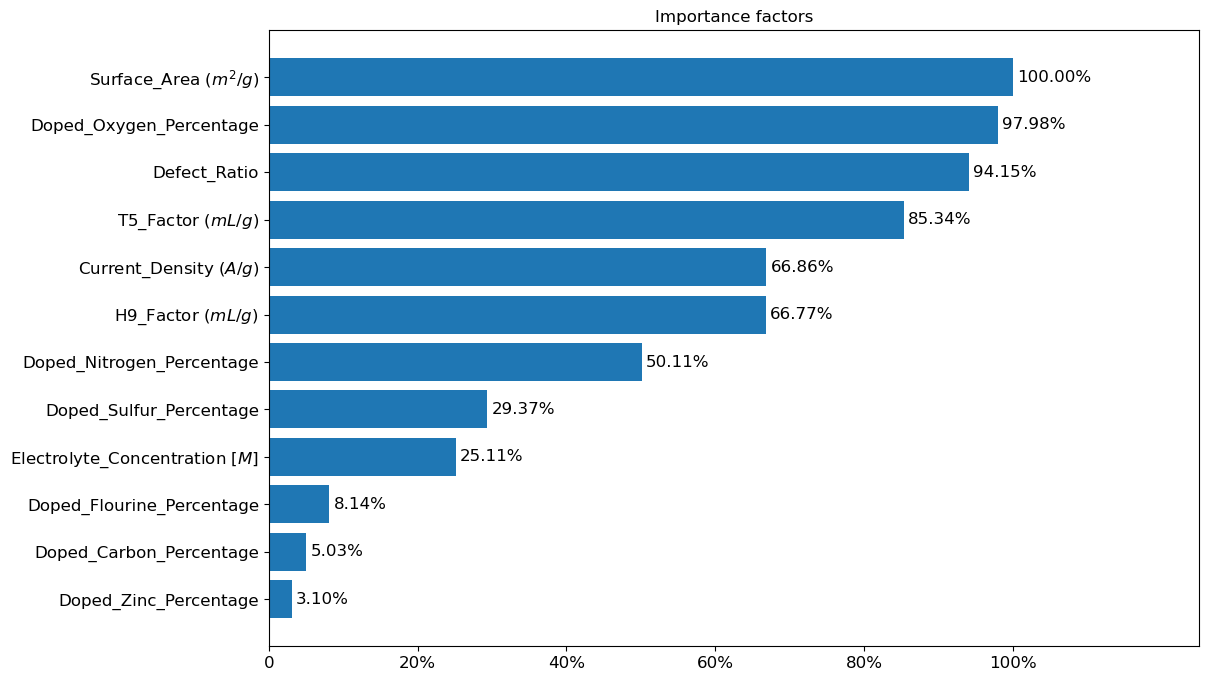

In [655]:
percentages = importance(best_B, 12, X_train, y_train, columns_dict)

From the bar plot above, we can conclude that the surface area is the most important feature with defect ratio, doped oxygen precentage, and T5 factor also being very significant. Therefore, we can guess that the feature bagging model has weakend the significance of the 4 important feature that we just mentioned.



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

Before we start the actual MLP process, we standardise the data set using the `standardise` function provided in the coding tasks.

In [555]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

We need to make sure that test set should not be used in any learning. Therefore, we use the mean and the standard deviation from the training set to standardise the test set.

In [556]:
X_test_std = standardise(X_test.to_numpy(), X_train_=X_train.to_numpy())
X_train_std = standardise(X_train.to_numpy())

Now we implement MLP with 2 hidden layers. We first define `dense`.

In [557]:
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    
    a = np.vstack([W @ x + b for x in X])
    return a

`activation` and `grad_activation` is required for the backpropagation

In [558]:
def activation(a):
    """activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h

## EDIT THIS FUNCTION
def grad_activation(a):
    """Gradient of activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.log(np.abs(a) + 1) / (1 + a ** 2) + (np.arctan(a) * np.sign(a)) / (np.abs(a) + 1)

    return grad

In [559]:
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size

we use the `backpropagate` function provided in the coding tasks.

In [560]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$. The

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h,
                          "b" : delta.sum(axis=0)})

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

`sgd_step` and `sgd` is identical to the functions provided in the coding tasks. The case where we have momentum will be explained below.

In [561]:
def sgd_step(X_train, y_train, mlp, learning_rate = 5e-5, momentum=None, v_t=None):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X_train)

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y_train, y_hat)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    if momentum is not None and v_t is not None:
        updated_layers, v_tplus1 = [], []
        for layer, grad, v in zip(mlp.layers, gradients, v_t):
            
            # Update weights with momentum.
            v_tplus1_W = momentum * v["W"] + learning_rate * grad["W"]
            W = layer["W"] - v_tplus1_W

            # Update biases with momentum.
            v_tplus_b = momentum * v["b"] + learning_rate * grad["b"]
            b = layer["b"] - v_tplus_b

            updated_layers.append({"W": W, "b": b,
                                #Keep the activation function.
                                "activation": layer["activation"],
                                "index": layer["index"]})
            
            v_tplus1.append({"W": v_tplus1_W, "b": v_tplus_b})
            
        return updated_layers, v_tplus1
    
    else:
        # mlp.layers and gradients are symmetric, as shown in the figure.
        updated_layers = []
        for layer, grad in zip(mlp.layers, gradients):
            W = layer["W"] - learning_rate * grad["W"]
            b = layer["b"] - learning_rate * grad["b"]
            updated_layers.append({"W": W, "b": b,
                                # keep the activation function.
                                "activation": layer["activation"],
                                # We use the index for asserts and debugging purposes only.
                                "index": layer["index"]})
    
        return updated_layers

In [562]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5,
        n_epochs=300, minibatchsize=8, seed=42, momentum=None):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """
    
    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))

    if momentum is not None:
        for i in epochs_bar:

            # shuffle data
            p = rng.permutation(len(y_train))
            X_train_shuffled = X_train[p]
            y_train_shuffled = y_train[p]

            v_t = [{"W": np.zeros_like(mlp.layers[i]["W"]), "b": np.zeros_like(mlp.layers[i]["b"])}
                      for i in range(len(mlp.layers))]

            for j in range(n_iterations):
                # get batch
                X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
                y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

                # apply sgd step
                updated_layers, v_tplus1 = sgd_step(X_batch, y_batch, mlp, learning_rate, momentum, v_t)

                # update weights and biases of MLP
                mlp.layers = updated_layers
                v_t = v_tplus1

            # compute loss at the end of each epoch
            y_hat_train, _ = mlp.predict(X_train)
            losses_train.append(mse_cal(y_train, y_hat_train).squeeze())
            y_hat_test, _ = mlp.predict(X_test)
            losses_test.append(mse_cal(y_test, y_hat_test).squeeze())

    else:
        for i in epochs_bar:

            # shuffle data
            p = rng.permutation(len(y_train))
            X_train_shuffled = X_train[p]
            y_train_shuffled = y_train[p]

            for j in range(n_iterations):
                #Get batch
                X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
                y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

                #Apply sgd step
                updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate)

                #Update weights and biases of MLP
                mlp.layers = updated_layers

            #Compute loss at the end of each epoch
            y_hat_train, _ = mlp.predict(X_train)
            losses_train.append(mse_cal(y_train, y_hat_train).squeeze())
            y_hat_test, _ = mlp.predict(X_test)
            losses_test.append(mse_cal(y_test, y_hat_test).squeeze())
            
    return mlp, losses_train, losses_test

In [563]:
# A lookup table for activation functions by their names.
activation_table = {
    "arctan":activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "arctan":grad_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


In [564]:
class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), ## <-- SOLUTION
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # predicted target is output of last layer
        return y_hat, forward_pass

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{50 \times 12}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{50}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{50\times 50}$, $k=1$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{50}$, $k=1$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(2)} \in\mathbb{R}^{1 \times 50}$
* Bias $\boldsymbol{b}^{(2)} \in\mathbb{R}^{1}$


In [565]:
mlp = MLP(seed=1)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "arctan")
mlp.add_layer(50, 1, "arctan")
print("Number of layers:",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

n_epochs = 300
mlp, losses_train, losses_test = sgd(X_train_std, y_train.to_numpy(), X_test_std, y_test.to_numpy(),
                                     mlp, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 3
Number of trainable parameters: 3251


  0%|          | 0/300 [00:00<?, ?it/s]

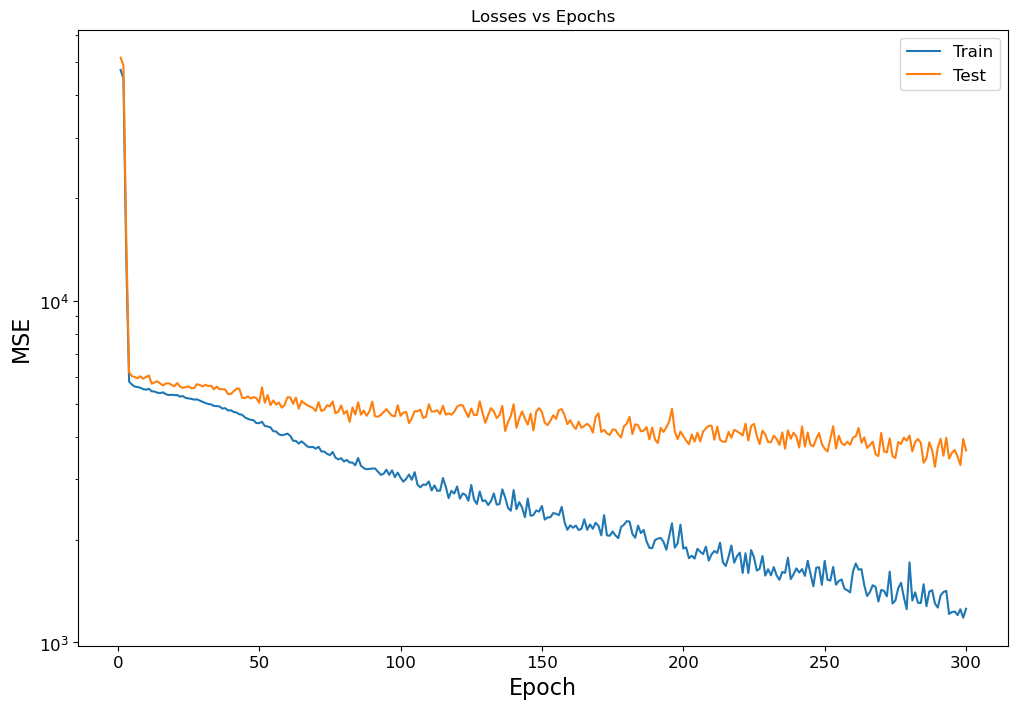

In [566]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE", yscale='log')
ax.legend()
plt.show()

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

Back to `sgd_step` and `sgd`.

we store the velocity vector $v_{t}$ in the list `v_t` and then calculate $v_{t+1}$ and store it in `v_tplus1`. Then, we update `v_t` as `v_tplus1`.

using the velocities, we implement \

$g_{t} = \nabla_{\theta}L(\theta_{t};D_{m}) $

$v_{t+1} = \beta v_{t} + \eta g_{t}$

$\theta_{t+1} = \theta_{t} - v_{t+1}$

In [567]:
mlp_with_momentum = MLP(seed=1)

mlp_with_momentum.add_layer(12, 50)
mlp_with_momentum.add_layer(50, 50, "arctan")
mlp_with_momentum.add_layer(50, 1, "arctan")

print("Number of layers:", mlp_with_momentum.n_layers())
print("Number of trainable parameters:", mlp_with_momentum.n_parameters())

n_epochs = 300
mlp_with_momentum, losses_train_momentum, losses_test_momentum = sgd(X_train_std, y_train.to_numpy(), X_test_std,
                                                                y_test.to_numpy(), mlp_with_momentum,
                                                                learning_rate = 5e-5, n_epochs=n_epochs,
                                                                minibatchsize=8, momentum=0.4)

Number of layers: 3
Number of trainable parameters: 3251


  0%|          | 0/300 [00:00<?, ?it/s]

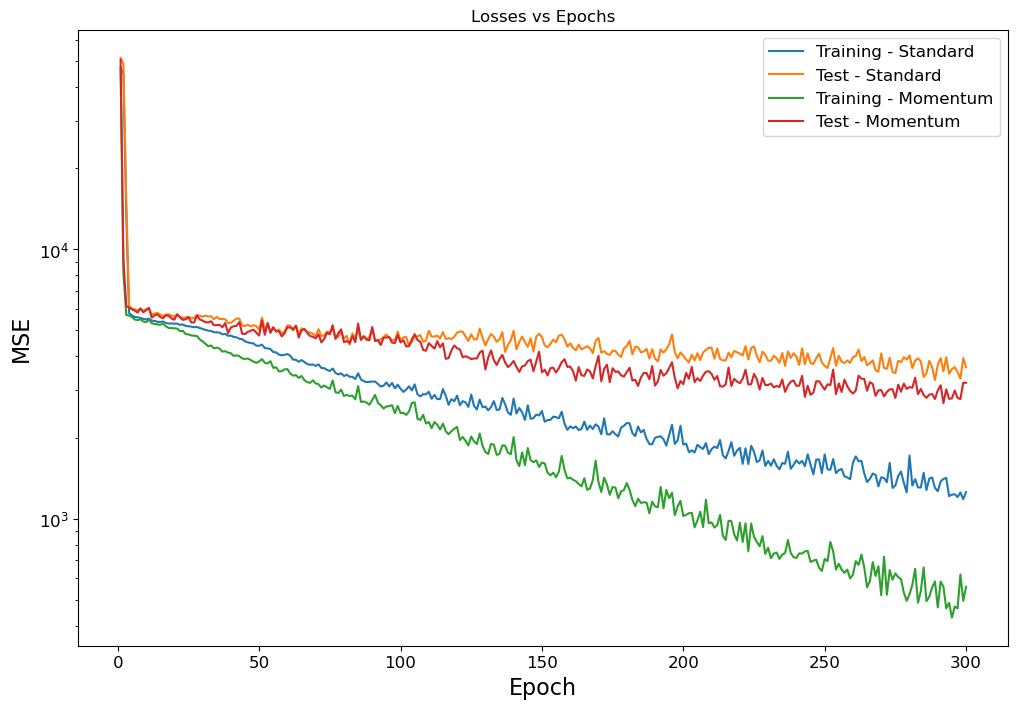

In [568]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Training - Standard")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test - Standard")
ax.plot(np.arange(1,n_epochs+1),losses_train_momentum, label="Training - Momentum")
ax.plot(np.arange(1,n_epochs+1),losses_test_momentum, label="Test - Momentum")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE", yscale='log')
ax.legend()
plt.show()

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

Create the extended set of features using `quadratic`.

In [762]:
def quadratic(X_train):
    
    npX, newX = X_train, X_train
    
    m, n = npX.shape
    
    for i in range(0, n):
        for j in range(i, n):
            
            col1, col2 = npX[:, i], npX[:, j]
            
            new_col = col1 * col2
            
            newX = np.c_[newX, new_col]
            
    return newX

X_train_modified = quadratic(X_train.to_numpy())
X_test_modified = quadratic(X_test.to_numpy())

X_train_mod_std = standardise(X_train_modified)
X_test_mod_std = standardise(X_test_modified, X_train_=X_train_modified)

Use the functions from the coding task for ridge regression 

In [763]:
def predict_ridge(X, beta):

    # X_test: K x D matrix of test inputs
    # beta: D x 1 vector of parameters
    # returns: prediction of f(X_test); K x 1 vector
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    prediction = X_aug @ beta

    return prediction

In [764]:
def ridge_estimate(X, y, penalty):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[0] = 0.0 # penalty excludes the bias term.
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y)
    return beta_ridge

We create `score_ridge` which calculates the MSE values and $R^{2}$ scores for the ridge regression model

In [765]:
def score_ridge(beta, X_test, y_test):
    """
    Inputs
    Parameters:
    beta (value): Beta estimate from ridge regression model.
    X_test (array-like): Test data.
    y_test (array-like): Target values of the test data.
    """

    #Predict the target values using the decision tree model
    y_pred = predict_ridge(X_test, beta)

    #Calculate the MSE and R^2 score
    
    mse_val = mse_cal(y_pred, y_test).squeeze()
    
    r2 = r2_score(y_pred, y_test)

    return f"MSE: {mse_val}, r2: {r2}"

In [1024]:
def ridge_regression(X_train, y_train, X_test, y_test, penalties):
    betas = []
    
    for penalty in penalties:
        betas.append(ridge_estimate(X_train, y_train, penalty))
    
    n = len(betas[0])
    
    fig, ax = plt.subplots(len(penalties), 1, figsize=(12,12))

    for r, val in enumerate(penalties):
        print(f"{val} Training Set Perfomrance {score_ridge(betas[r], X_train, y_train)}")
        print(f"{val} Test Set Performance {score_ridge(betas[r], X_test, y_test)}")
        ax[r].plot(range(n), betas[r], label = r"$\lambda$ = "+str(val))
        ax[r].legend()
        ax[r].set(xlabel=r"$i$", ylabel=r"$\beta$[i]")
    
    return betas

0.0001 Training Set Perfomrance MSE: 3792.7746726626433, r2: 0.4277018087137917
0.0001 Test Set Performance MSE: 4965.180190192765, r2: 0.24793880512326638
1 Training Set Perfomrance MSE: 4024.445461148831, r2: 0.39274461123508764
1 Test Set Performance MSE: 4463.090705837438, r2: 0.3239888180281657
1000 Training Set Perfomrance MSE: 5323.508736146564, r2: 0.19672675443854482
1000 Test Set Performance MSE: 5787.870972466872, r2: 0.12332825947716364


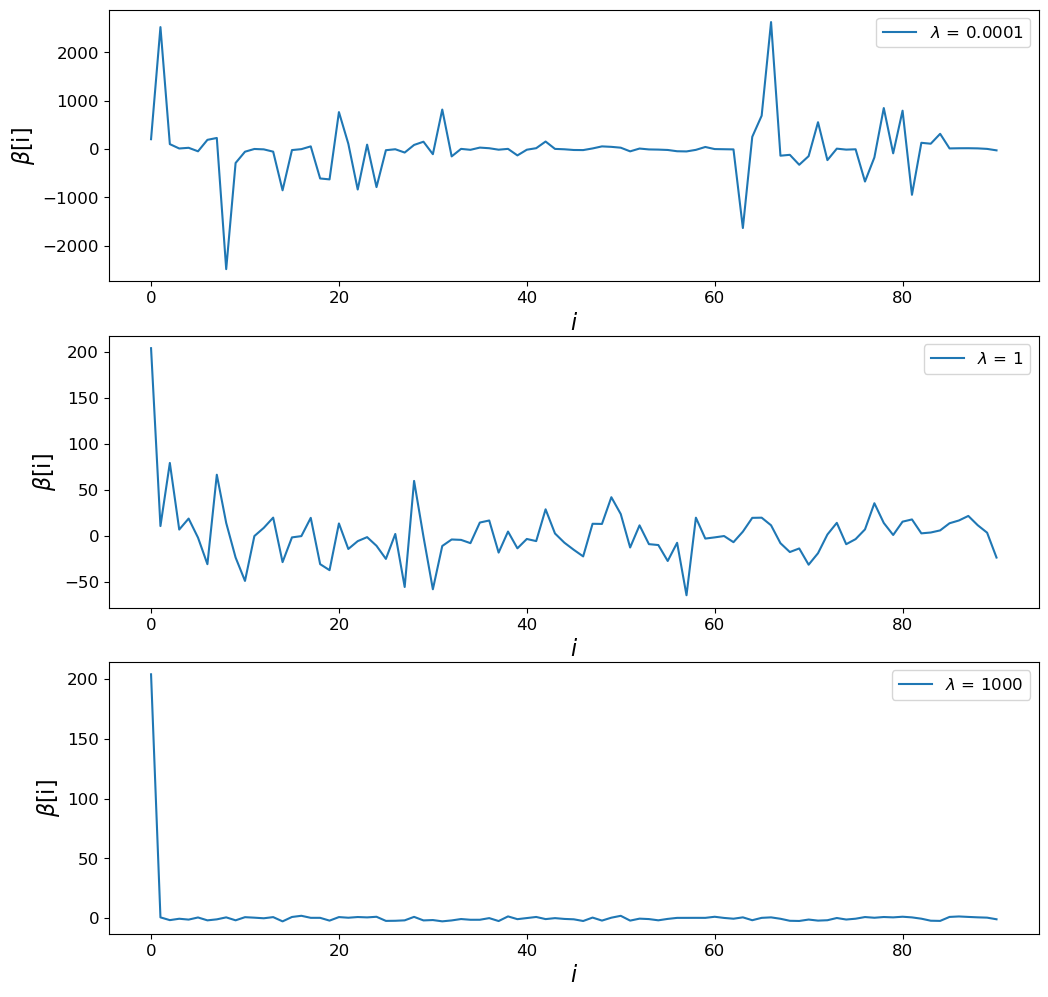

In [1026]:
betas = ridge_regression(X_train_mod_std, y_train.to_numpy(), X_test_mod_std, y_test.to_numpy(), [0.0001, 1, 1000])

First, for the case $\lambda = 0.0001$ the $\beta$ coefficients show multiple, but not to many peaks while the the rest ofthe features have coefficient values near 0. The coefficient value that is the most extreme is $\beta_{2}$ which is the coefficient for Defect ratio. Also, we see another extreme coefficient value at $\beta_{8}$ which corresponds to the H9 Factor. We also realise that for $\beta_{i}$ for $i > 12$ there exists a few extreme values which indicates that there is potentially some important information in a few of the quadratic features.

Second, for the case $\lambda = 1$, the fact that there is a peak at $\beta_{2}$ (which corresponds to Defect ratio is unchanged.

Finally, for the case $\lambda = 1000$, as we can see from the relatively flat shaped line, we can think that the penalty parameter is too high.

In [768]:
def cross_validation_ridge(X, y, penalty):
    """
    Perform 5-fold cross validation on the Ridge linear regression model.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        peanlty: penalty value
    Returns:
        (float): the average MSE of the 5-fold cross validation.
    """
    np.random.seed(7)
    p = np.random.permutation(len(X))
    X = X[p]
    y = y[p]
    N = X.shape[0]
    folds_indices = np.array_split(np.arange(len(y)), 5)
    MSEs = []
    
    for test_indices in folds_indices:
        train_indices = list(set(range(N)) - set(test_indices))
        X_train, X_test = X[train_indices, :], X[test_indices, :]
        y_train, y_test = y[train_indices], y[test_indices]
        
        # Train the Ridge linear regression model
        beta = ridge_estimate(X_train, y_train, penalty)
        
        # Test the Ridge linear regression model
        MSEs.append(mse_cal(predict_ridge(X_test, beta), y_test))
        
    return np.mean(MSEs)

In [769]:
def choose_best_lamb(X_train, y_train, X_test, y_test):
    """
    Find the optimal B for the random forest model.
    Args:
        X_train: training features, of shape (N, p).
        y_train: vector of training labels, of shape (N,).
        X_test: testing sample features, of shape (N, p).
        y_test: vector of testing sample labels, of shape (N,).
    Returns:
        (int): the optimal penalty.
    """
    original_penalties = np.r_[0, np.geomspace(start=0.0001, stop=1000, num=1000)]
    original_MSEs = []
    optimal_penalty = original_penalties[0]
    optimal_MSE = np.inf

    original_penalty_bar = tqdm(original_penalties)

    for penalty in original_penalty_bar:

        mean_MSE = cross_validation_ridge(X_train, y_train, penalty)

        if mean_MSE < optimal_MSE:
            optimal_MSE = mean_MSE
            optimal_penalty = penalty

        beta = ridge_estimate(X_train, y_train, penalty)

        original_MSEs.append(mean_MSE)
        
    optimal_beta = ridge_estimate(X_train, y_train, optimal_penalty)
    print(f"Optimal Penalty - {optimal_penalty:.3f}")
    print("---------------------------------------------------------------------")
    print("Training -", score_ridge(optimal_beta, X_train, y_train))
    print("Test -", score_ridge(optimal_beta, X_test, y_test))
        
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(original_penalties, original_MSEs)
    ax.set(xlabel =r"$\lambda$", ylabel = r"MSE")
    
    ax.axhline(y=np.min(original_MSEs), color='r', linestyle='-')
    ax.axvline(x=optimal_penalty, color='r', linestyle='dotted')
    plt.show()

    return optimal_penalty

  0%|          | 0/1001 [00:00<?, ?it/s]

Optimal Penalty - 79.415
---------------------------------------------------------------------
Training - MSE: 4628.698006902843, r2: 0.3015679216448418
Test - MSE: 5323.6289722570455, r2: 0.19364562561815213


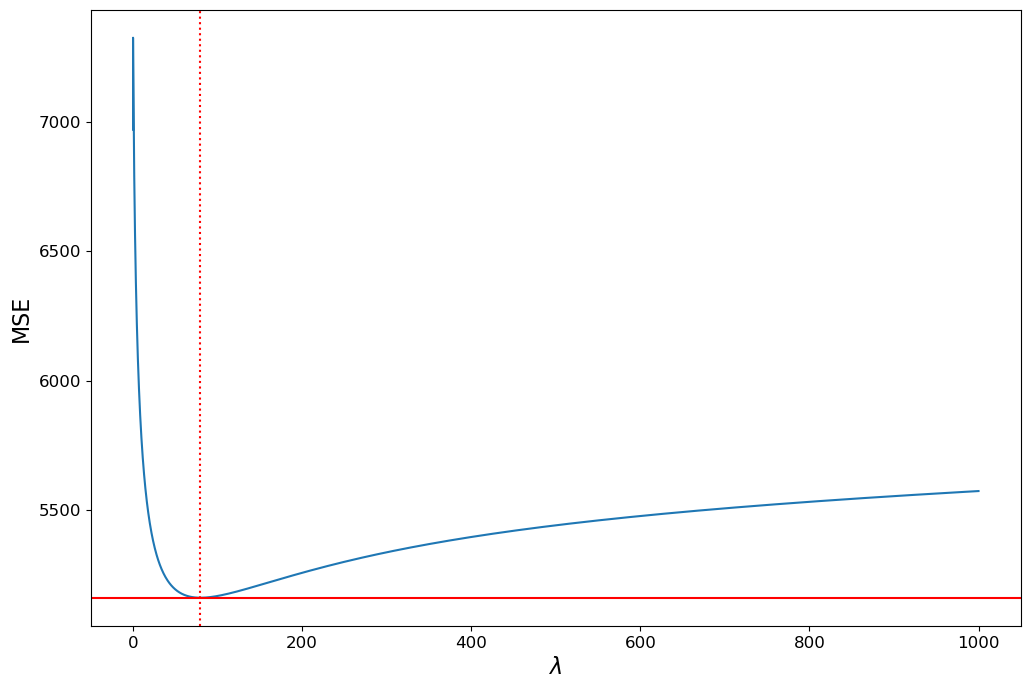

In [770]:
quad_optimal_penalty = choose_best_lamb(X_train_mod_std, y_train.to_numpy(), X_test_mod_std, y_test.to_numpy())

  0%|          | 0/1001 [00:00<?, ?it/s]

Optimal Penalty - 13.247
---------------------------------------------------------------------
Training - MSE: 5561.901419247397, r2: 0.1607552789016936
Test - MSE: 5767.906572995559, r2: 0.1263522081650782


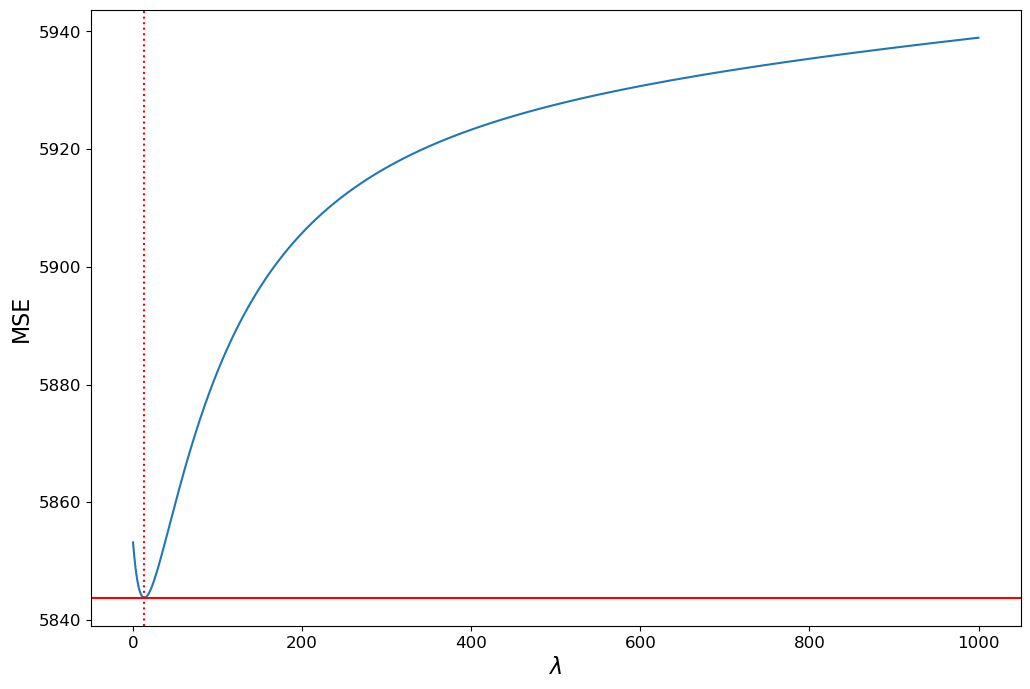

In [771]:
normal_optimal_penalty = choose_best_lamb(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())

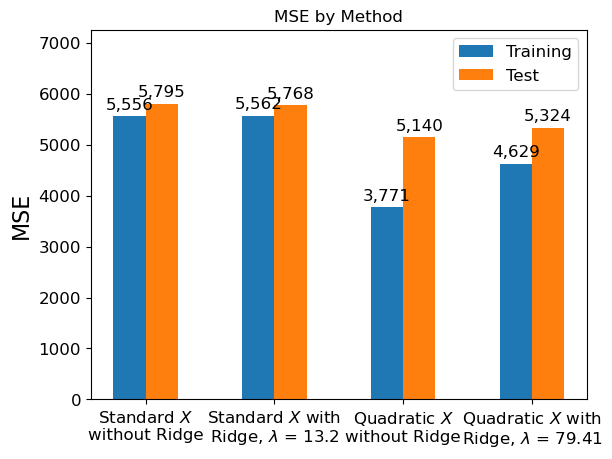

In [772]:
figsize=(12, 10)

# Tuple of methods
methods = ("Normal $X$\nwithout Ridge", "Normal $X$ with\nRidge, $\lambda$ = " + str(normal_optimal_penalty)[0:4],
           "Extended $X$\nwithout Ridge", "Extended $X$ with\nRidge, $\lambda$ = " + str(quad_optimal_penalty)[0:5])

betas = [ridge_estimate(X_train.to_numpy(), y_train.to_numpy(), 0),
         ridge_estimate(X_train.to_numpy(), y_train.to_numpy(), normal_optimal_penalty),
         ridge_estimate(X_train_mod_std, y_train.to_numpy(), 0),
         ridge_estimate(X_train_mod_std, y_train.to_numpy(), quad_optimal_penalty)]

predictions_train = [predict_ridge(X_train.to_numpy(), betas[0]), predict_ridge(X_train.to_numpy(), betas[1]),
                     predict_ridge(X_train_mod_std, betas[2]), predict_ridge(X_train_mod_std, betas[3])]

predictions_test = [predict_ridge(X_test.to_numpy(), betas[0]), predict_ridge(X_test.to_numpy(), betas[1]),
                     predict_ridge(X_test_mod_std, betas[2]), predict_ridge(X_test_mod_std, betas[3])]

mse_cal_values_3 = {
    'Training': [mse_cal(y_train.to_numpy(), y_pred).squeeze() for y_pred in predictions_train],
    'Test': [mse_cal(y_test.to_numpy(), y_pred).squeeze() for y_pred in predictions_test]                           
}

x = np.arange(len(methods))
width = 0.25
multiplier = 0

for data, values in mse_cal_values_3.items():
    offset = width*multiplier
    rects = plt.bar(x + offset, values, width, label=data)
    plt.bar_label(rects, padding=3, fmt='{:,.0f}')
    multiplier += 1

plt.ylabel('MSE')
plt.title('MSE by Method')
plt.xticks(x + width/2, methods)
plt.legend(loc='upper right')
plt.ylim(0, 7250)

plt.show()

From the plot above, we first see that the MSE values for the normal X is much highes than the ones from extended quadratic X. This suggests that using the extended quadratic X might be better than the normal X. However, as we can see from the test set data, extended quadratic X is prone to overfitting.

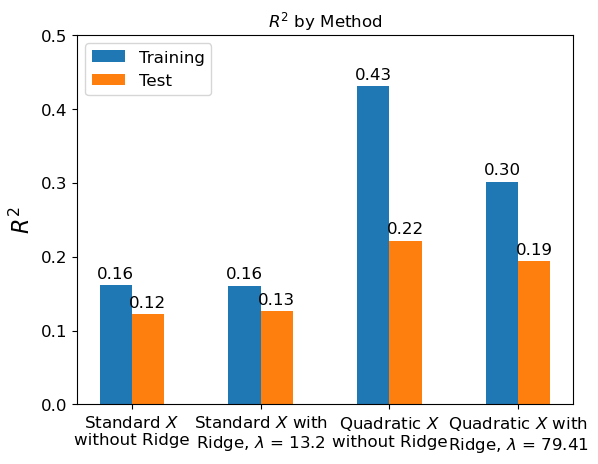

In [773]:
figsize=(12, 10)

R2_values_3 = {
    'Training': [r2_score(y_pred, y_train.to_numpy()) for y_pred in predictions_train],
    'Test': [r2_score(y_pred, y_test.to_numpy()) for y_pred in predictions_test]                           
}


x = np.arange(len(methods))
width = 0.25
multiplier = 0

for data, values in R2_values_3.items():
    offset = width*multiplier
    rects = plt.bar(x + offset, values, width, label=data)
    plt.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

plt.ylabel(r"$R^2$")
plt.title(r"$R^2$ by Method")
plt.xticks(x + width/2, methods)
plt.legend(loc='upper left')
plt.ylim(0, 0.5)

plt.show()

The $R^{2}$ scores also agrees with the trend that we discovered in the MSE values plot. As a result, we can conclude that there is no perfect model that is suitable for a complicated data set like what we are working with right now.



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

Load data

In [1031]:
data_2 = pd.read_csv('./brain_cancer_samples.csv')
data_test_2 = pd.read_csv('./brain_cancer_test.csv')

We also drop the Patient ID column because it is not useful data.

In [1032]:
feature_names = data_2.columns.drop('Patient ID').drop('Class')

In [1033]:
X_train_2 = pd.DataFrame(data_2, columns=feature_names)
X_test_2 = pd.DataFrame(data_test_2, columns=feature_names)

In [1034]:
y_train_2 = data_2['Class']
y_test_2 = data_test_2['Class']

Standardise the training set and the test set.

In [1035]:
X_train_2_std = standardise(X_train_2.to_numpy())
X_test_2_std = standardise(X_test_2.to_numpy())

`eudclidian_distance` is used to calculate the distance between the two data points.

In [1036]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1)) ## <-- SOLUTION

`k_neighbours` from the coding task determines k number of closest points.

In [1037]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train (hint: use python's list comprehension)
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test] ## <-- SOLUTION

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

`predict_k` from the coding task is a prediction function for unweighted kNN.

In [1038]:
def predict_k(X_train, y_train, X_test, k=5):
    # each of the k neighbours contributes equally to the classification of any data point in X_test
    neighbours = k_neighbours(X_train, X_test, k=k)
    # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension)
    y_pred = np.array([np.argmax([np.count_nonzero(y_train[neighbour] == 0) ,np.count_nonzero(y_train[neighbour] == 1), np.count_nonzero(y_train[neighbour] == 2)]) for neighbour in neighbours])

    return y_pred

The weighed version of kNN.

In [1039]:
def w_predict_k(X_train, y_train, X_test, weight, k=5):
    # each of the k neighbours contributes equally to the classification of any data point in X_test
    neighbours = k_neighbours(X_train, X_test, k=k)
    
    # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension)
    y_pred = np.array([np.argmax(np.array([np.count_nonzero(y_train[neighbour] == 0) ,np.count_nonzero(y_train[neighbour] == 1), np.count_nonzero(y_train[neighbour] == 2)]) * weight) for neighbour in neighbours])

    return y_pred

In [1040]:
def metric_kNN(X_train, y_train, X_test, y_test, k=5):
    """
    Calculate the confusion matrix and performance measures for the k-nearest neighbours algorithm.
    Args:
        X_train (np.array): training sample features, of shape (N, p).
        y_train (np.array): vector of training values, of shape (N,).
        X_test (np.array): testing sample features, of shape (M, p).
        y_test (np.array): vector of testing values, of shape (M,).
        k (int): neighbours
    Returns:
        (np.array): the confusion matrix of the k-nearest neighbours algorithm.
        (dict): a dictionary containing the performance measures of the k-nearest neighbours algorithm.
    """

    y_pred = predict_k(X_train, y_train, X_test, k=k)
    
    y_count = np.bincount(y_test, minlength = 3)

    c = np.zeros((3, 3))
    
    #create the confusion matrix
    for y_p, y_t in zip(y_pred, y_test):
        c[y_p, y_t] += 1
        
    micro_accuracy = np.sum(np.diag(c)) / np.sum(c)
    
    macro_accuracy = np.mean(np.diag(c) / np.sum(c, axis=0))

    class_accuracy = np.mean((y_count * np.diag(c)) / (np.sum(c, axis=0) * np.mean(y_count)))

    micro_precision = np.sum(np.diag(c)) / np.sum(c)
    
    macro_precision = np.mean(np.diag(c) / np.sum(c, axis=1))

    class_precision = np.mean((y_count * np.diag(c)) / (np.sum(c, axis=1) * np.mean(y_count)))
    
    measures = {"Micro Accuracy": micro_accuracy, "Macro Accuracy": macro_accuracy, "Class Accuracy": class_accuracy,
                "Micro Precision": micro_precision, "Macro Precision": macro_precision, "Class Precision": class_precision}
    
    return c, measures

For class weight metrics, we take the true frequency of each class in the test set reweight the classes.

In [1041]:
y_pred = predict_k(X_train_2_std, y_train_2.to_numpy(), X_test_2_std, k=6)

The calculate the micro average accuracy by creating the confusion matrix.

`cross_validation_score` calculates the micro average accuracy using five-fold cross-validation.

In [1042]:
def cross_validation_score(X_train, y_train, folds, k):
    
    N = X_train.shape[0]
    fold_size = N // folds
    p = np.random.permutation(len(y_train))
    X_train = X_train[p]
    y_train = y_train[p]
    scores = []
    for i in range(folds):
        val_indexes = list(range(i * fold_size, (i + 1) * fold_size))
        train_indexes = list(set(range(N)) - set(val_indexes))

        X_train_i = X_train[train_indexes]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes] # <- SOLUTION
        y_val_i = y_train[val_indexes] # <- SOLUTION

        c, vals = metric_kNN(X_train_i, y_train_i, X_val_i, y_val_i, k=k) # <- SOLUTION
        scores.append(vals['Micro Accuracy'])

    # Return the average score
    return sum(scores) / len(scores) # <- SOLUTION

`choose_best_k` determines the ideal k value that minimises the MSE value of the prediction.

In [1043]:
def choose_best_k(X_train, y_train, folds, k_range):
    k_scores = np.zeros((len(k_range),))

    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
    
    plt.plot(k_range, k_scores)
    plt.title('K')
    plt.show()
    
    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index]

In [1044]:
cross_validation_score(X_train_2.to_numpy(), y_train_2.to_numpy(), 5, k = 5)

0.5724137931034483

C:\Users\Juno\AppData\Local\Temp\ipykernel_30496\3774034643.py:33: RuntimeWarning: invalid value encountered in divide
  macro_precision = np.mean(np.diag(c) / np.sum(c, axis=1))
C:\Users\Juno\AppData\Local\Temp\ipykernel_30496\3774034643.py:35: RuntimeWarning: invalid value encountered in divide
  class_precision = np.mean((y_count * np.diag(c)) / (np.sum(c, axis=1) * np.mean(y_count)))
C:\Users\Juno\AppData\Local\Temp\ipykernel_30496\3774034643.py:27: RuntimeWarning: invalid value encountered in divide
  macro_accuracy = np.mean(np.diag(c) / np.sum(c, axis=0))
C:\Users\Juno\AppData\Local\Temp\ipykernel_30496\3774034643.py:29: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.mean((y_count * np.diag(c)) / (np.sum(c, axis=0) * np.mean(y_count)))


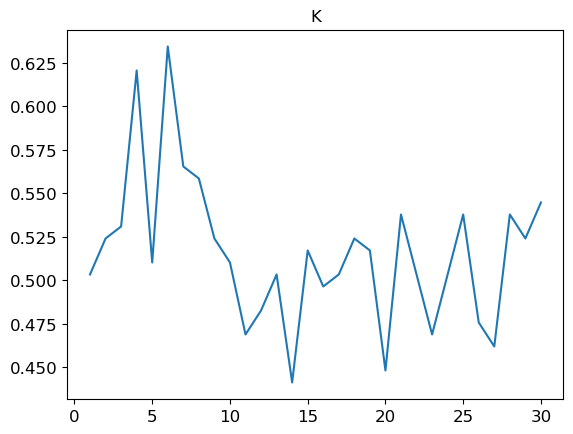

In [1045]:
best_k = choose_best_k(X_train_2.to_numpy(), y_train_2.to_numpy(), 5, np.arange(1,31))

In [1046]:
best_k

6

In [1047]:
metric_kNN(X_train_2_std, y_train_2.to_numpy(), X_test_2_std, y_test_2.to_numpy(), k=best_k)

(array([[ 9.,  8.,  0.],
        [ 9., 27.,  3.],
        [ 0.,  0.,  4.]]),
 {'Micro Accuracy': 0.6666666666666666,
  'Macro Accuracy': 0.6142857142857142,
  'Class Accuracy': 0.6666666666666666,
  'Micro Precision': 0.6666666666666666,
  'Macro Precision': 0.7405731523378583,
  'Class Precision': 0.6793363499245851})

In [1048]:
print(np.bincount(y_train_2))

[47 80 18]


We notice that class 2 is the minority class.

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

We use the inverse of the frequency of each class to reweight the data points. This will help the prediction of the minority class 2 by giving it more weight.

In [1049]:
def inv_freq(y_train):
    
    total = len(y_train)
    
    weights = []
    
    for r in range(3):
        
        weights.append(total / np.count_nonzero(y_train == r))
        
    return np.array(weights)

In [1050]:
w = inv_freq(y_train_2.to_numpy())

In [1051]:
w

array([3.08510638, 1.8125    , 8.05555556])

In [1052]:
def metric_kNN_w(X_train, y_train, X_test, y_test, k=5, w=None):
    """
    Calculate the confusion matrix and performance measures for the k-nearest neighbours algorithm.
    Args:
        X_train (np.array): training sample features, of shape (N, p).
        y_train (np.array): vector of training labels, of shape (N,).
        X_test (np.array): testing sample features, of shape (M, p).
        y_test (np.array): vector of testing labels, of shape (M,).
        k (int): the number of neighbours to consider.
        weights (dict): the weights to assign to each class.
    Returns:
        (np.array): the confusion matrix of the k-nearest neighbours algorithm.
        (dict): a dictionary containing the performance measures of the k-nearest neighbours algorithm.
    """

    y_pred = w_predict_k(X_train, y_train, X_test, weight=w, k=k)

    y_bin = np.bincount(y_test)
    
    c = np.zeros((3, 3))
    
    # fill the confusion matrix with predictions on the left and truth on the top
    for y_p, y_t in zip(y_pred, y_test):
        c[y_p, y_t] += 1
        
    micro_accuracy = np.sum(np.diag(c)) / np.sum(c)
    
    macro_accuracy = np.mean(np.diag(c) / np.sum(c, axis=0))

    class_accuracy = np.mean((y_bin * np.diag(c)) / (np.sum(c, axis=0) * np.mean(y_bin)))

    micro_precision = np.sum(np.diag(c)) / np.sum(c)
    
    macro_precision = np.mean(np.diag(c) / np.sum(c, axis=1))

    class_precision = np.mean((y_bin * np.diag(c)) / (np.sum(c, axis=1) * np.mean(y_bin)))
    
    vals = {"Micro Accuracy": micro_accuracy, "Macro Accuracy": macro_accuracy, "Class Accuracy": class_accuracy,
                "Micro Precision": micro_precision, "Macro Precision": macro_precision, "Class Precision": class_precision}
    
    return c, vals

In [1053]:
metric_kNN_w(X_train_2_std, y_train_2.to_numpy(), X_test_2_std, y_test_2.to_numpy(), k=best_k, w=w)[1]

{'Micro Accuracy': 0.6666666666666666,
 'Macro Accuracy': 0.6523809523809524,
 'Class Accuracy': 0.6666666666666666,
 'Micro Precision': 0.6666666666666666,
 'Macro Precision': 0.632422969187675,
 'Class Precision': 0.6650735294117647}

In [1054]:
a = metric_kNN(X_train_2_std, y_train_2.to_numpy(), X_test_2_std, y_test_2.to_numpy(), k=5)[1]

b = metric_kNN_w(X_train_2_std, y_train_2.to_numpy(), X_test_2_std, y_test_2.to_numpy(), k=5, w=w)[1]

metric_data1 = [a["Micro Accuracy"], a["Macro Accuracy"], a["Class Accuracy"], a["Macro Precision"], a["Micro Precision"], a["Class Precision"]]
metric_data2 = [b["Micro Accuracy"], b["Macro Accuracy"], b["Class Accuracy"], b["Macro Precision"], b["Micro Precision"], b["Class Precision"]]

df1 = pd.DataFrame([metric_data1, metric_data2],index=['Normal', 'Weighted'], columns= ["Micro Accuracy", "Macro Accuracy",  "Class Accuracy", "Macro Precision", "Micro Precision", "Class Precision"])

df1

,Micro Accuracy,Macro Accuracy,Class Accuracy,Macro Precision,Micro Precision,Class Precision
Normal,0.666667,0.614286,0.666667,0.740573,0.666667,0.679336
Weighted,0.583333,0.595767,0.583333,0.536222,0.583333,0.600342


For the weighted versioni, we see a noticeable drop in metrics across all types. We see biggest drop in macro averaged metrics. This is because the reweighting strategy ends up in a worse performance on predicting class 0 and class 1 data points.

Performance based on micro averaged metrics also dropped because the increasing the weight of class 2 data points led to some inaccurate predictions of class 2.

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

We replace class 2 with class 1 to reformulate the classification task as a binary classification task.

In [1055]:
y_train_2_r = y_train_2.replace(2,1)

In [1056]:
y_test_2_r = y_test_2.replace(2,1)

perform the first step of the 2 step kNN by training a kNN model for the binary classification task

In [1057]:
first_step = predict_k(X_train_2.to_numpy(), y_train_2_r.to_numpy(), X_test_2.to_numpy(), k=best_k)

Find the index of class 1 predictions as we have to perform the second step of the 2 step kNN on these data points.

In [1058]:
one_index = np.where(predict_k(X_train_2.to_numpy(), y_train_2_r.to_numpy(), X_test_2.to_numpy(), k=5) == 1)

Filter training and test data by excluding class 0 data which is irrelevant to the second step of the process.

In [1059]:
y_train_filter = data_2['Class'][data_2['Class'].isin([1,2])]

In [1060]:
y_test_filter = data_test_2['Class'][data_test_2['Class'].isin([1,2])]

In [1061]:
X_train_filter = pd.DataFrame(data_2[data_2['Class'].isin([1,2])], columns=feature_names)

In [1062]:
X_test_filter = pd.DataFrame(data_test_2[data_test_2['Class'].isin([1,2])], columns=feature_names)

Perform the second step of the 2 step kNN by training another kNN model for the subsequent binary classifiction between class 1 and class 2. This time we are using k = 1.

In [1063]:
second_step = predict_k(X_train_filter.to_numpy(), y_train_filter.to_numpy(), X_test_2.to_numpy()[one_index], k=1)

Now that we have predicted the class 2 data points, we replace the corresponding class 1 data points from the first step with class 2.

In [1064]:
first_step[one_index] = second_step

The formulas to calculate the metrics are the same as the formulas above.

In [1065]:
def macro_avg_acc(y_pred, y_test):

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.mean(np.diag(c) / np.sum(c, axis=0))
    
def macro_avg_pre(y_pred, y_test):

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.mean(np.diag(c) / np.sum(c, axis=1))

def micro_avg_acc(y_pred, y_test):

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.sum(np.diag(c)) / np.sum(c)
    
def micro_avg_pre(y_pred, y_test):

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.sum(np.diag(c)) / np.sum(c)

In [1066]:
def class_weight_acc(y_pred, y_test):

    y_count = y_count = np.bincount(y_test, minlength = 3)

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.mean((y_count * np.diag(c)) / (np.sum(c, axis=0) * np.mean(y_count)))
    
def class_weight_pre(y_pred, y_test):

    y_count = y_count = np.bincount(y_test, minlength = 3)

    c = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # create the confusion matrix
    for i, j in zip(y_pred, y_test):
        c[i, j] += 1

    return np.mean((y_count * np.diag(c)) / (np.sum(c, axis=1) * np.mean(y_count)))

In [1067]:
df1

,Micro Accuracy,Macro Accuracy,Class Accuracy,Macro Precision,Micro Precision,Class Precision
Normal,0.666667,0.614286,0.666667,0.740573,0.666667,0.679336
Weighted,0.583333,0.595767,0.583333,0.536222,0.583333,0.600342


In [1068]:
list_of_2 = [macro_avg_acc(first_step, y_test_2.to_numpy()), micro_avg_acc(first_step, y_test_2.to_numpy()), class_weight_acc(first_step, y_test_2.to_numpy()), macro_avg_pre(first_step, y_test_2.to_numpy()), micro_avg_pre(first_step, y_test_2.to_numpy()), class_weight_pre(first_step, y_test_2.to_numpy())]

df2 = pd.DataFrame([metric_data1, metric_data2, list_of_2],index=['Normal', 'Weighted', '2step'], columns= ["Micro Accuracy", "Macro Accuracy",  "Class Accuracy", "Macro Precision", "Micro Precision", "Class Precision"])

df2

,Micro Accuracy,Macro Accuracy,Class Accuracy,Macro Precision,Micro Precision,Class Precision
Normal,0.666667,0.614286,0.666667,0.740573,0.666667,0.679336
Weighted,0.583333,0.595767,0.583333,0.536222,0.583333,0.600342
2step,0.795238,0.783333,0.783333,0.787393,0.783333,0.773451


We notice the that the 2 step kNN model performs much better across all metrics. So implementing the 2 step kNN model is a good strategy.



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

We start by standardising the data set.

In [1069]:
X_train_2_std = standardise(X_train_2.to_numpy(), X_train_=None)

In [1070]:
X_test_2_std = standardise(X_test_2.to_numpy(), X_train_=X_train_2.to_numpy())

Again, we change class 2 data points into class 1 to reformulate as binary classification task.

In [1071]:
y_train_2_r = y_train_2.replace(2,1)
y_test_2_r = y_test_2.replace(2,1)

$ \frac{1}{1 + e^{-(z^{T}\beta + \beta_{0})}} $

In [1072]:
def logistic(z, beta, b0):
    return 1. / (1. + np.exp(-(z @ beta + b0)))

$h_{\beta, \beta_{0}}(x)$

In [1073]:
def predict_log(X, beta, b0):
    y_log = logistic(X, beta, b0)
    return y_log.squeeze()

In [1074]:
def initialise(X_train):
    """    
    Argument:
    size: Size of the parameter vector beta
  
    Returns:
    beta: Initialised vector of shape (size, 1)
    
    """
  
    beta = np.zeros((X_train.shape[1], 1))
      
    return beta

In [1075]:
def propagate(X, y, beta, b0, penalty):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    
    grads = dict()
    y_log = predict_log(X, beta, b0)

    # Mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + penalty * np.linalg.norm(beta) ** 2 / 2
    
    # Derivatives
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1, 1) + (penalty * beta).reshape(-1, 1)

    db0 = np.mean(y_log - y)
    
    mean_loss = np.squeeze(mean_loss)
  
    # Store gradients in a dictionary
    grads.update({'dbeta': dbeta})
    
    grads.update({'db0': db0})
  
    return grads, mean_loss

In [1076]:
def optimise(X, y, beta, b0, penalty=0.0025, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    
    params = dict()
    
    mean_loss_history = []
    
    for i in range(num_iterations):

        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = propagate(X, y, beta, b0, penalty)  ## <-- SOLUTION
      
        # Retrieving derivatives from grads
        dbeta = grads['dbeta']
        db0 = grads['db0']
      
        # Updating procedure
        beta = beta - learning_rate * dbeta
        
        b0 = b0 - learning_rate * db0
        
        # Record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
  
    # Saving parameters and gradients in dictionary
    params.update({'beta': beta})
    params.update({'b0': b0})
    grads.update({'dbeta': dbeta})
    grads.update({'db0': db0})
  
    return params, grads, mean_loss_history

In [1077]:
def predict_l(X_test, beta, b0):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
  
    # Predicting the probabilities
    y_log = predict_log(X_test, beta, b0)
  
    y_pred = y_log.round().reshape(1, -1) # <-- SOLUTION
  
    return y_pred

In [1078]:
def model(X_train, y_train, X_test, y_test, penalty=0.0025, num_iterations=2000, learning_rate=0.1, print_loss=False):
    
    # Initialising parameters with zeros
    beta = initialise(X_train)
    b0 = 0
    
    # Gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, b0, penalty=penalty, num_iterations=num_iterations, learning_rate=learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    b0 = parameters['b0']

    # Predicting test and training set examples
    y_pred_test = predict_l(X_test, beta, b0)
    y_pred_train = predict_l(X_train, beta, b0)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'b0': b0, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
  
    return d

In [1079]:
d = model(X_train_2_std, y_train_2_r.to_numpy(), X_test_2_std, y_test_2_r.to_numpy(), num_iterations=1000)

Training accuracy: 77.93103448275862 %
Test accuracy: 81.66666666666667 %


We actually see that the model does better for the test set which demonstrates that the model generalises well without overfitting.

In [1080]:
d

{'mean_loss_history': [0.6931471805599453,
  0.5443146918761013,
  0.5335580394059894,
  0.5302297180342843,
  0.5286057448889081,
  0.5275675613665884,
  0.526782949948754,
  0.526132969376772,
  0.5255696848319371,
  0.5250716523295419],
 'y_pred_test': array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.]]),
 'y_pred_train': array([[1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
         0.,

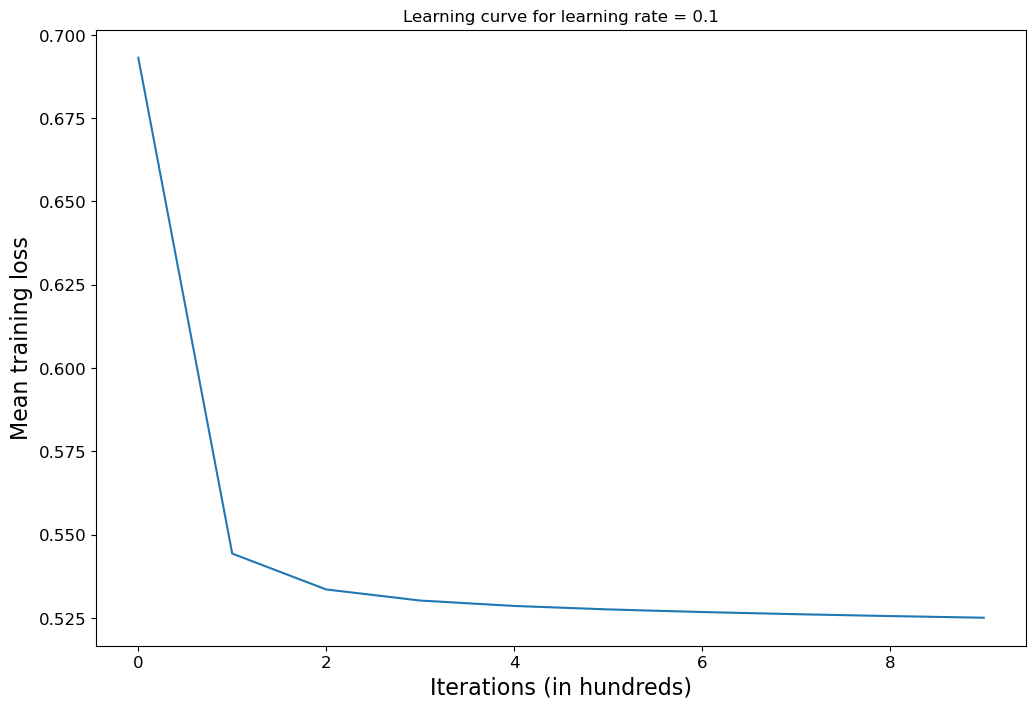

In [1081]:
loss_history = np.squeeze(d['mean_loss_history'])
plt.figure(figsize=(12,8))
plt.ylabel('Mean training loss')
plt.xlabel('Iterations (in hundreds)')
plt.title('Learning curve for learning rate = ' + str(d['learning_rate']))
plt.plot(loss_history);

In [1082]:
def pr_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N
  
    Returns:
    auc: Area Under the Curve (AUC)
    tpr_l: List of true positive rate (TPR) values for each scanned threshold
    fpr_l: List of false positive rate (FPR) values for each scanned threshold
    thresholds: Scanned thresholds sorted in decreasing order
    
    """
    # List of distinct values in y_log, sorted sorted in decreasing order
    thresholds = reversed(sorted(set(y_log))) # <-- SOLUTION
    pre_l, rec_l = [], []

    for threshold in thresholds:
        # Thresholding
        y_thresholded = (y_log >= threshold)

        # True positives
        tp = np.sum(y_true & y_thresholded)
        # True negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))

        pre = tp / (tp + fp) # <-- SOLUTION
        rec = tp / (tp + fn) # <-- SOLUTION
        pre_l.append(pre)
        rec_l.append(rec)
    
    auc = np.trapz(pre_l, rec_l)
    
    return auc, pre_l, rec_l, thresholds

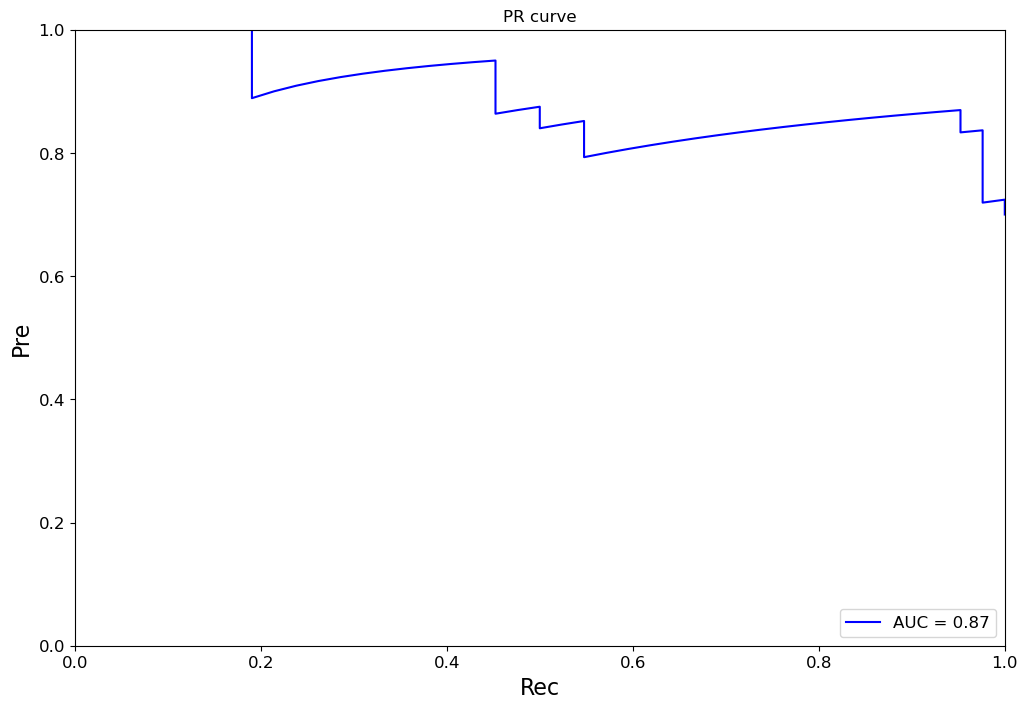

In [1083]:
y_log = predict_log(X_test_2_std, d['beta'], d['b0'])
auc, pre, rec, th = pr_curve(y_test_2_r, y_log)

plt.figure(figsize=(12,8))
plt.title(f'PR curve')
plt.plot(rec, pre, 'b', label=f'AUC = {auc:0.2f}')
plt.legend(loc='lower right')
plt.xlabel('Rec')
plt.ylabel('Pre')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

The PR curve will display the relationship between precision and recall. For the binary classification task where we have an unbalanced data set, it is more appropriate to use a PR curve instead of the ROC curve the two metrics, preicison and recall, do not consider true negatives as relevant information.

The model above performs well as we can see the AUC = 0.86

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

We will now formulate the kernelised version of the logistic regression model. The new loss function of can be derived using the laplacian kernel:


$k(x, y) = $exp$(-\alpha \lVert x - y \rVert_{1})$


The new loss function will look like,

$E(L) = - \frac{1}{N} \sum_{N}^{i=1}[y_{(i)}logh_{u, \beta_{0}}(k_{i}) + (1-y^{(i)})log(1 - h_{u, \beta_{0}}(k_{i}))] + \frac{\lambda}{2}u^{T}Ku$

$k_{i}$ indicates the ith row of the kernel matrix $K$ that is defined below.

In order to prove that optimising this loss is a convex optimisation problem, we must prove that the hessian matrix is positive definite.

we first define kernel matrix $K$ by

$K_{ij} = k(x^{(i)}, x^{(j)}) = \phi(x^{(i)}, x^{(j)})$

For simplification of notation we say

$e_{i} = e^{-(k_{i}u + \beta_{0})}$

To define the hessian matrix $H_{f}$, we need to find the second order partial derivatives.

$\frac{\partial^{2} E(L)}{\partial \beta_{0}^{2}} = \frac{1}{N} \sum_{i} \frac{e_{i}}{(1 + e_{i})^{2}} = \frac{1}{N} \sum_{i}[ \frac{\sqrt{e_{i}}}{(1 + e_{i})}]^{2}$

$\frac{\partial^{2} E(L)}{\partial u_{j}\partial \beta_{0}} = \frac{1}{N} \sum_{i} K_{ji}\frac {e_{i}}{(1 + e_{i})^{2}}$

$\frac{\partial^{2} E(L)}{\partial \beta_{0}\partial u_{j}} = \frac{1}{N} \sum_{i} K_{ij}\frac {e_{i}}{(1 + e_{i})^{2}}$

$\frac{\partial^{2} E(L)}{\partial u_{j}\partial u_{k}} = \frac{1}{N} \sum_{i} K_{j}K_{ji}i\frac {e_{i}}{(1 + e_{i})^{2}}$

We now write the hessian matrix

$H_{f} = \frac{1}{2} A^{T} A + \lambda M$

where the matrix $A$ is equal to

\begin{pmatrix}
\frac{\sqrt{e_{i}}}{(1 + e_{i})}^{2} & \frac{K_{11}\sqrt{e_{i}}}{(1 + e_{i})}^{2} & \dots & \frac{K_{N1}\sqrt{e_{i}}}{(1 + e_{i})}^{2}\\
\vdots & \ddots & \ddots & \vdots\\
\vdots & \ddots & \ddots & \vdots\\
\frac{\sqrt{e_{i}}}{(1 + e_{i})}^{2} & \frac{K_{1N}\sqrt{e_{i}}}{(1 + e_{i})}^{2} & \dots & \frac{K_{NN}\sqrt{e_{i}}}{(1 + e_{i})}^{2}
\end{pmatrix}

and the matrix $M$ is equal to

\begin{pmatrix}
0 & \dots & \dots & 0\\
\vdots &  &  & \\
\vdots & & K & \\
\vdots & & & \\
\end{pmatrix}

This is equivalent to

\begin{pmatrix}
0 & \dots & \dots & 0\\
\vdots &  &  & \\
\vdots & & \phi^{T}\phi & \\
\vdots & & & \\
\end{pmatrix}

which is the product of 


\begin{pmatrix}
0 & \dots & \dots & 0\\
\vdots &  &  & \\
\vdots & & \phi^{T} & \\
\vdots & & & \\
\end{pmatrix}

and

\begin{pmatrix}
0 & \dots & \dots & 0\\
\vdots &  &  & \\
\vdots & & \phi & \\
\vdots & & & \\
\end{pmatrix}

we will define this augmented $\phi$ matrix as matrix $m$.

For positive definitve, we need to prove that $v^{T}H_{f}v > 0$ for all non zero vector $v$.

$v^{T}H_{f}v = \frac{1}{N}v^{T} A^{T} A v + \lambda v^{T}Mv =  \frac{1}{2}v^{T} A^{T} A v + \lambda v^{T}m^{T}mv$

Finally, if we take norm,

$v^{T}H_{f}v = \frac{1}{N}\lVert Av \rVert^{2} + \lambda \lVert mv \rVert^{2} > 0$

Therefore, we have proved that the hessian matrix is positive definite and the opimsation is convex.


<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

In [1084]:
# First we need a function to calculate the kernel given the data #
def kernel_matrix(X1, X2, alpha):
    """
    Arguments:
    X1, X2: two input datasets
    sigma: hyperparameter in Gaussian kernel (look up for its interpretation if you are interested)

    Returns:
    kernel: K matrix
    """

    n1,m1 = X1.shape
    
    n2,m2 = X2.shape
    
    kernel = np.zeros((n1,n2))

    for i in range(n1):
        
        exponent = alpha * np.sum(np.abs(X2 - X1[i]), axis=1) ## <-- SOLUTION
        
        kernel[i,:] = np.exp(-exponent)

    return kernel

In [1085]:
def k_logistic(z1, z2, u, b0, alpha):
    return 1. / (1. + np.exp(-(kernel_matrix(z1, z2, alpha) @ u + b0)))

In [1086]:
def k_predict_log(z1, z2, u, b0, alpha):
    y_log = k_logistic(z1, z2, u, b0, alpha)  ## <-- SOLUTION
    return y_log.squeeze()

In [1087]:
def k_propagate(X, y, u, b0, penalty, alpha):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    
    grads = dict()
    
    y_log = k_predict_log(X, X, u, b0, alpha)
    
    K = kernel_matrix(X, X, alpha)
    
    # Mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + penalty * (u.T @ K @ u) / 2
    
    # Derivatives
    du = np.mean(K * (y_log - y), axis=1).reshape(-1, 1) + (penalty * (K @ u)).reshape(-1, 1) ## <-- SOLUTION

    db0 = np.mean(y_log - y)
    
    mean_loss = np.squeeze(mean_loss)

    # Store gradients in a dictionary
    grads.update({'du': du})
    
    grads.update({'db0': db0})
  
    return grads, mean_loss

In [1088]:
def k_optimise(X, y, u, b0, alpha, penalty=0.0025, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    
    params = dict()
    
    mean_loss_history = []
    
    for i in range(num_iterations):

        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = k_propagate(X, y, u, b0, penalty, alpha)  ## <-- SOLUTION
      
        # Retrieving derivatives from grads
        du = grads['du']
        db0 = grads['db0']
      
        # Updating procedure
        u = u - learning_rate * du
        
        b0 = b0 - learning_rate * db0

        mean_loss_history.append(mean_loss)
        
        # Record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
  
    # Saving parameters and gradients in dictionary
    params.update({'u': u})
    params.update({'b0': b0})
    grads.update({'du': du})
    grads.update({'db0': db0})
  
    return params, grads, mean_loss_history

In [1089]:
def k_predict_l(X_train, X_test, u, b0, alpha):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    
    N_test = X_test.shape[1]
    y_pred = np.zeros((N_test, 1))
    u = u.reshape(X_train.shape[0], 1)
  
    # Predicting the probabilities
    y_log = k_predict_log(X_test, X_train, u, b0, alpha)
  
    y_pred = y_log.round().reshape(1, -1) # <-- SOLUTION
  
    return y_pred

In [1090]:
def k_model(X_train, y_train, X_test, y_test, alpha, penalty=0.0025, num_iterations=1000, learning_rate=0.1, print_loss=False):
    
    # Initialising parameters with zeros
    K = kernel_matrix(X_train, X_train, alpha)
    u = initialise(K)
    b0 = 0
    
    # Gradient descent
    parameters, grads, mean_loss_history = k_optimise(X_train, y_train, u, b0, alpha, penalty=penalty, num_iterations=num_iterations, learning_rate=learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    u = parameters['u']
    b0 = parameters['b0']

    # Predicting test and training set examples
    y_pred_test = k_predict_l(X_train, X_test, u, b0, alpha)
    y_pred_train = k_predict_l(X_train, X_train, u, b0, alpha)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'u': u, 'b0': b0, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
  
    return d

In [1091]:
d1 = k_model(X_train_2_std, y_train_2_r.to_numpy(), X_test_2_std, y_test_2_r.to_numpy(), alpha= 100, penalty=0.0025, num_iterations=1000, learning_rate=0.1)

Training accuracy: 68.9655172413793 %
Test accuracy: 70.0 %


In [1092]:
d2 = k_model(X_train_2_std, y_train_2_r.to_numpy(), X_test_2_std, y_test_2_r.to_numpy(), alpha= 0.3, penalty=0.0025, num_iterations=1000, learning_rate=0.1)

Training accuracy: 86.20689655172414 %
Test accuracy: 85.0 %


We can see that $\alpha = 0.3$ performs better than $\alpha = 100$.

We also notice that setting $\alpha = 100$ makes the performance worse than the non kernelised version.

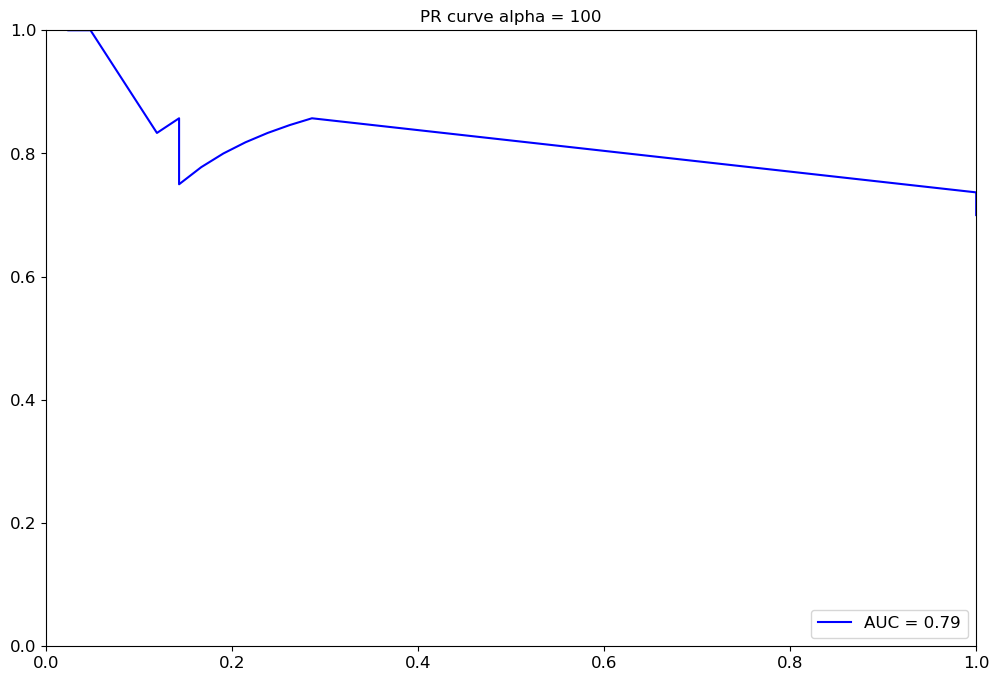

In [1093]:
y_log = k_predict_log(X_test_2_std, X_train_2_std, d1['u'], d1['b0'], alpha= 100)
auc, pre, rec, th = pr_curve(y_test_2_r, y_log)

plt.figure(figsize=(12,8))
plt.title(f'PR curve alpha = 100')
plt.plot(rec, pre, 'b', label=f'AUC = {auc:0.2f}')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

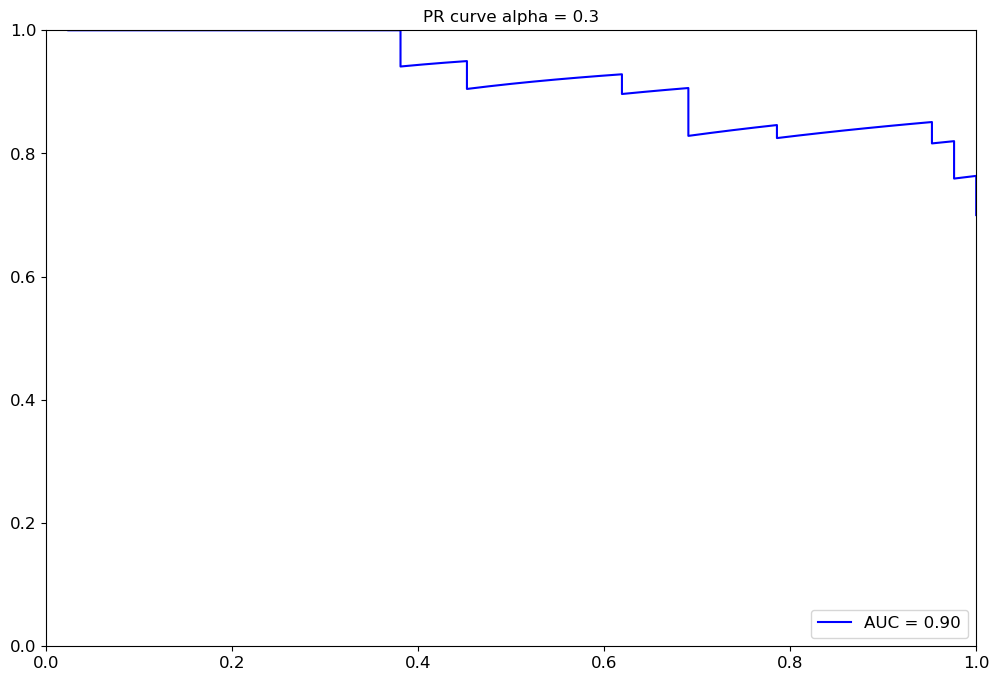

In [1094]:
y_log = k_predict_log(X_test_2_std, X_train_2_std, d2['u'], d2['b0'], alpha= 0.3)
auc, pre, rec, th = pr_curve(y_test_2_r, y_log)

plt.figure(figsize=(12,8))
plt.title(f'PR curve alpha = 0.3')
plt.plot(rec, pre, 'b', label=f'AUC = {auc:0.2f}')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

We see that the PR curve agrees with the trend that we discovered above with $\alpha = 0.3$ having the highest AUC value and $\alpha = 100$ having the lowest.